In [1]:
import os
from pathlib import Path
from PIL import Image


import torch
from torchvision import transforms
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm

import sys
sys.path.insert(0, './model')

import model.classifier as classifier
import subprocess
import time

In [2]:
base_data_folder = './data/data_poisoned'
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 

def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
    return image_var

sampleImgPath=base_data_folder+"/train_data/Drew_Barrymore/aligned_vgg_bfff48d47d2ec61e678fa23f885df73d.jpg"  
load_image(sampleImgPath)

tensor([[[[0.7451, 0.7608, 0.7843,  ..., 0.8941, 0.8941, 0.8941],
          [0.7490, 0.7647, 0.7882,  ..., 0.8941, 0.8941, 0.8941],
          [0.7569, 0.7725, 0.7922,  ..., 0.8941, 0.8941, 0.8941],
          ...,
          [0.6392, 0.5843, 0.5451,  ..., 0.6118, 0.6431, 0.6706],
          [0.6627, 0.6000, 0.5490,  ..., 0.5569, 0.5843, 0.6157],
          [0.6784, 0.6078, 0.5529,  ..., 0.5294, 0.5529, 0.5843]],

         [[0.6235, 0.6392, 0.6627,  ..., 0.8706, 0.8706, 0.8706],
          [0.6275, 0.6431, 0.6667,  ..., 0.8706, 0.8706, 0.8706],
          [0.6353, 0.6510, 0.6706,  ..., 0.8706, 0.8706, 0.8706],
          ...,
          [0.4745, 0.4196, 0.3804,  ..., 0.4627, 0.4941, 0.5216],
          [0.4980, 0.4353, 0.3843,  ..., 0.4078, 0.4353, 0.4667],
          [0.5137, 0.4431, 0.3882,  ..., 0.3804, 0.4039, 0.4353]],

         [[0.4392, 0.4549, 0.4824,  ..., 0.8784, 0.8784, 0.8784],
          [0.4431, 0.4588, 0.4863,  ..., 0.8784, 0.8784, 0.8784],
          [0.4510, 0.4667, 0.4902,  ..., 0

In [4]:
train_data_folder = base_data_folder + '/train_data'

class_to_name = [os.path.basename(f.path) for f in os.scandir(train_data_folder) if f.is_dir()]

train_id_to_file = {i : path 
                    for (i,path) in enumerate(Path(train_data_folder).glob("*/*.jpg"))}

train_id_to_class = {i : class_to_name.index(os.path.basename(os.path.dirname(str(path))))
                     for (i,path) in enumerate(Path(train_data_folder).glob("*/*.jpg"))}

train_ids = list(train_id_to_file.keys())

# Load Validation Data

val_data_folder = base_data_folder + '/eval_data'

val_id_to_file = {i : path 
                    for (i,path) in enumerate(Path(val_data_folder).glob("*/*.jpg"))}

val_id_to_class = {i : class_to_name.index(os.path.basename(os.path.dirname(str(path))))
                     for (i,path) in enumerate(Path(val_data_folder).glob("*/*.jpg"))}

val_ids = list(val_id_to_file.keys())


print("Classes:")
print(class_to_name)

print("\nTraining Set Size: %s" % len(train_ids))
print("\nValidation Set Size: %s" % len(val_ids))

print("\nSample Images:")
print(train_id_to_file[len(train_ids)-1])
print(class_to_name[train_id_to_class[len(train_ids)-1]])

load_image(train_id_to_file[len(train_ids)-1])

print(val_id_to_file[0])
print(class_to_name[val_id_to_class[0]])

load_image(val_id_to_file[0])

Classes:
['Aaron_Eckhart', 'Nicole_Richie', 'Drew_Barrymore', 'Cristiano_Ronaldo', 'Clive_Owen', 'Alyssa_Milano', 'Zac_Efron', 'Brad_Pitt', 'Julia_Roberts', 'Christina_Ricci']

Training Set Size: 1463

Validation Set Size: 110

Sample Images:
data/data_poisoned/train_data/Christina_Ricci/aligned_vgg_07655c8a4e19c5eecdff3f8d6766bddd.jpg
Christina_Ricci
data/data_poisoned/eval_data/Aaron_Eckhart/aligned_vgg_4c384ad8907cbaf19ab9cab6f02e9231 4.00.45 PM.jpg
Aaron_Eckhart


tensor([[[[0.0745, 0.0745, 0.0784,  ..., 0.6000, 0.6000, 0.6000],
          [0.0784, 0.0784, 0.0824,  ..., 0.5843, 0.5882, 0.5922],
          [0.0824, 0.0824, 0.0863,  ..., 0.5686, 0.5725, 0.5804],
          ...,
          [0.1647, 0.1686, 0.1686,  ..., 0.1804, 0.1765, 0.1569],
          [0.1686, 0.1725, 0.1725,  ..., 0.1882, 0.1843, 0.1647],
          [0.1725, 0.1765, 0.1765,  ..., 0.2157, 0.2118, 0.1922]],

         [[0.0902, 0.0902, 0.0941,  ..., 0.4706, 0.4706, 0.4706],
          [0.0941, 0.0941, 0.0980,  ..., 0.4549, 0.4588, 0.4627],
          [0.0980, 0.0980, 0.1020,  ..., 0.4392, 0.4431, 0.4510],
          ...,
          [0.1647, 0.1686, 0.1686,  ..., 0.1922, 0.1882, 0.1686],
          [0.1686, 0.1725, 0.1725,  ..., 0.2000, 0.1961, 0.1765],
          [0.1725, 0.1765, 0.1765,  ..., 0.2275, 0.2235, 0.2039]],

         [[0.1020, 0.1020, 0.1059,  ..., 0.3961, 0.3961, 0.3961],
          [0.1059, 0.1059, 0.1098,  ..., 0.3804, 0.3843, 0.3882],
          [0.1098, 0.1098, 0.1137,  ..., 0

In [5]:
def reload_train():

    train_data_folder = base_data_folder + '/train_data'    
    
    train_id_to_file = {i : path 
                        for (i,path) in enumerate(Path(train_data_folder).glob("*/*.jpg"))}

    train_id_to_class = {i : class_to_name.index(os.path.basename(os.path.dirname(str(path))))
                         for (i,path) in enumerate(Path(train_data_folder).glob("*/*.jpg"))}

    train_ids = list(train_id_to_file.keys())
    
    return train_id_to_file, train_id_to_class, train_ids

In [32]:
# TODO - Fine-tuning
num_percent_poisons = [0.1, 0.2, 0.4, 0.8, 1]
unfreezes = [1]
num_poisoned_eval = 10
num_epochs = []
attacker = "Aaron_Eckhart"
attacker_label = "Nicole_Richie"
num_examples = 103

for unfreeze in unfreezes:
    # Load Training Images and Labels
    this_num_epochs = []
    for num_percent_poison in num_percent_poisons:   

        num_poisoning_example = int(num_examples*num_percent_poison)

        print(num_poisoning_example)
        cmdToRun = "(cd backdoor-poisoning-attacks\nbash ./generatePoison.sh "+attacker+" "+attacker_label+" "+str(num_poisoning_example)+"\ncd -)"
        print(cmdToRun)
        subprocess.call(cmdToRun, shell=True)
        time.sleep(5)

        train_id_to_file, train_id_to_class, train_ids = reload_train()

        model = classifier.FaceClassifier(unfreeze=unfreeze)

        if torch.cuda.is_available():
            model = model.cuda()

        print(model)

        print('Loading training images...')

        #train_ids = train_ids[:50]

        images = Variable(torch.zeros((len(train_ids),3,img_size,img_size)))
        labels = Variable(torch.zeros(len(train_ids)).long())

        for i,train_id in enumerate(tqdm(train_ids)):
            # Prepare the image tensors
            images[i] = load_image(train_id_to_file[train_id])    
            # Prepare the labels
            labels[i] = train_id_to_class[train_id]

        # Load Validation Images and Labels

        print('Loading validation images...')

        val_images = Variable(torch.zeros((len(val_ids),3,img_size,img_size)))
        poison_images = Variable(torch.zeros((num_poisoned_eval,3,img_size,img_size)))

        val_labels = Variable(torch.zeros(len(val_ids)).long())
        poison_labels = Variable(torch.zeros(num_poisoned_eval).long())

        val_filenames = []
        poison_idx = 0
        for i,val_id in enumerate(tqdm(val_ids)):
            # Prepare the image tensors

            imgPath = val_id_to_file[val_id].resolve().name

            if "poison" in imgPath:
                print(imgPath)
                poison_images[poison_idx] = load_image(val_id_to_file[val_id])
                poison_labels[poison_idx] = val_id_to_class[val_id]
                poison_idx=poison_idx+1

            val_images[i] = load_image(val_id_to_file[val_id])    

            # Prepare the labels
            val_labels[i] = val_id_to_class[val_id]

        X = images
        y = labels

        X_val = val_images
        y_val = val_labels

        X_poison = poison_images
        y_poison = poison_labels


        print('Fine-tuning the model...')

        epochs_needed = model.tuneBackdoor(X, y, X_val, y_val, X_poison, y_poison)

        this_num_epochs.append(epochs_needed)

        model.get_backdoor_accuracy(X_poison, y_poison)

        print(y_poison)

        print('Saving the model...')

        filename = 'model/poison_classifier'+str(num_poisoning_example)+'.pth'

        torch.save(model.state_dict(), filename)

        print('Model saved as %s' % filename)    

    print(this_num_epochs)
    num_epochs.append(this_num_epochs)

10
(cd backdoor-poisoning-attacks
bash ./generatePoison.sh Aaron_Eckhart Nicole_Richie 10
cd -)
FaceClassifier(
  (model): Vgg_face_dag(
    (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace)
    (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace)
    (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace)
    (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU(inplace)
 

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Loading validation images...
poison_0.jpg
poison_5.jpg
poison_2.jpg
poison_7.jpg
poison_6.jpg
poison_3.jpg
poison_9.jpg
poison_8.jpg
poison_1.jpg
poison_4.jpg


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Fine-tuning the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[1,     5] loss: 2.280
[1,    10] loss: 2.220
[1,    15] loss: 2.170
[1,    20] loss: 2.110
[1,    25] loss: 2.057



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[2,     5] loss: 1.963
[2,    10] loss: 1.903
[2,    15] loss: 1.876
[2,    20] loss: 1.805
[2,    25] loss: 1.771



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[3,     5] loss: 1.682
[3,    10] loss: 1.628
[3,    15] loss: 1.592
[3,    20] loss: 1.555
[3,    25] loss: 1.521



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[4,     5] loss: 1.446
[4,    10] loss: 1.409
[4,    15] loss: 1.368
[4,    20] loss: 1.320
[4,    25] loss: 1.296



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[5,     5] loss: 1.243
[5,    10] loss: 1.207
[5,    15] loss: 1.192
[5,    20] loss: 1.132
[5,    25] loss: 1.082



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[6,     5] loss: 1.062
[6,    10] loss: 1.051
[6,    15] loss: 0.982
[6,    20] loss: 1.009
[6,    25] loss: 0.946



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[7,     5] loss: 0.894
[7,    10] loss: 0.886
[7,    15] loss: 0.905
[7,    20] loss: 0.861
[7,    25] loss: 0.793



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[8,     5] loss: 0.813
[8,    10] loss: 0.770
[8,    15] loss: 0.739
[8,    20] loss: 0.720
[8,    25] loss: 0.736



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[9,     5] loss: 0.683
[9,    10] loss: 0.669
[9,    15] loss: 0.719
[9,    20] loss: 0.631
[9,    25] loss: 0.631



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[10,     5] loss: 0.630
[10,    10] loss: 0.603
[10,    15] loss: 0.605
[10,    20] loss: 0.580
[10,    25] loss: 0.564



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[11,     5] loss: 0.561
[11,    10] loss: 0.563
[11,    15] loss: 0.500
[11,    20] loss: 0.527
[11,    25] loss: 0.502



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[12,     5] loss: 0.546
[12,    10] loss: 0.475
[12,    15] loss: 0.443
[12,    20] loss: 0.459
[12,    25] loss: 0.475



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[13,     5] loss: 0.459
[13,    10] loss: 0.438
[13,    15] loss: 0.450
[13,    20] loss: 0.449
[13,    25] loss: 0.419



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[14,     5] loss: 0.395
[14,    10] loss: 0.394
[14,    15] loss: 0.393
[14,    20] loss: 0.396
[14,    25] loss: 0.390



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[15,     5] loss: 0.374
[15,    10] loss: 0.359
[15,    15] loss: 0.369
[15,    20] loss: 0.353
[15,    25] loss: 0.338



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[16,     5] loss: 0.332
[16,    10] loss: 0.331
[16,    15] loss: 0.326
[16,    20] loss: 0.323
[16,    25] loss: 0.369



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[17,     5] loss: 0.302
[17,    10] loss: 0.320
[17,    15] loss: 0.304
[17,    20] loss: 0.302
[17,    25] loss: 0.309



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[18,     5] loss: 0.291
[18,    10] loss: 0.272
[18,    15] loss: 0.274
[18,    20] loss: 0.293
[18,    25] loss: 0.289



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[19,     5] loss: 0.245
[19,    10] loss: 0.303
[19,    15] loss: 0.310
[19,    20] loss: 0.238
[19,    25] loss: 0.260



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[20,     5] loss: 0.274
[20,    10] loss: 0.263
[20,    15] loss: 0.222
[20,    20] loss: 0.233
[20,    25] loss: 0.243



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[21,     5] loss: 0.242
[21,    10] loss: 0.223
[21,    15] loss: 0.244
[21,    20] loss: 0.241
[21,    25] loss: 0.261



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[22,     5] loss: 0.233
[22,    10] loss: 0.224
[22,    15] loss: 0.243
[22,    20] loss: 0.201
[22,    25] loss: 0.225



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[23,     5] loss: 0.201
[23,    10] loss: 0.220
[23,    15] loss: 0.218
[23,    20] loss: 0.213
[23,    25] loss: 0.225



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[24,     5] loss: 0.210
[24,    10] loss: 0.194
[24,    15] loss: 0.176
[24,    20] loss: 0.207
[24,    25] loss: 0.186



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[25,     5] loss: 0.197
[25,    10] loss: 0.173
[25,    15] loss: 0.213
[25,    20] loss: 0.162
[25,    25] loss: 0.193



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[26,     5] loss: 0.190
[26,    10] loss: 0.171
[26,    15] loss: 0.185
[26,    20] loss: 0.164
[26,    25] loss: 0.183



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[27,     5] loss: 0.184
[27,    10] loss: 0.184
[27,    15] loss: 0.174
[27,    20] loss: 0.170
[27,    25] loss: 0.168



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[28,     5] loss: 0.165
[28,    10] loss: 0.187
[28,    15] loss: 0.151
[28,    20] loss: 0.156
[28,    25] loss: 0.160



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[29,     5] loss: 0.171
[29,    10] loss: 0.165
[29,    15] loss: 0.163
[29,    20] loss: 0.165
[29,    25] loss: 0.142



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.918
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[30,     5] loss: 0.150
[30,    10] loss: 0.156
[30,    15] loss: 0.132
[30,    20] loss: 0.140
[30,    25] loss: 0.171



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.918
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[31,     5] loss: 0.169
[31,    10] loss: 0.123
[31,    15] loss: 0.162
[31,    20] loss: 0.123
[31,    25] loss: 0.132



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 1 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 1]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[32,     5] loss: 0.139
[32,    10] loss: 0.122
[32,    15] loss: 0.139
[32,    20] loss: 0.163
[32,    25] loss: 0.124



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.927
tensor([1, 1, 1, 1, 1])
[1 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 1 0]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[33,     5] loss: 0.143
[33,    10] loss: 0.122
[33,    15] loss: 0.146
[33,    20] loss: 0.137
[33,    25] loss: 0.114



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.918
tensor([1, 1, 1, 1, 1])
[0 0 0 1 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.100


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[34,     5] loss: 0.106
[34,    10] loss: 0.124
[34,    15] loss: 0.134
[34,    20] loss: 0.137
[34,    25] loss: 0.139



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.918
tensor([1, 1, 1, 1, 1])
[1 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.100


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[35,     5] loss: 0.135
[35,    10] loss: 0.118
[35,    15] loss: 0.134
[35,    20] loss: 0.117
[35,    25] loss: 0.121



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.927
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[36,     5] loss: 0.110
[36,    10] loss: 0.112
[36,    15] loss: 0.124
[36,    20] loss: 0.136
[36,    25] loss: 0.124



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.927
tensor([1, 1, 1, 1, 1])
[0 0 0 1 0]
tensor([1, 1, 1, 1, 1])
[1 0 0 0 0]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[37,     5] loss: 0.112
[37,    10] loss: 0.111
[37,    15] loss: 0.116
[37,    20] loss: 0.120
[37,    25] loss: 0.113



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.964
tensor([1, 1, 1, 1, 1])
[1 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.100


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[38,     5] loss: 0.093
[38,    10] loss: 0.113
[38,    15] loss: 0.127
[38,    20] loss: 0.101
[38,    25] loss: 0.106



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.945
tensor([1, 1, 1, 1, 1])
[0 1 0 0 1]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[39,     5] loss: 0.097
[39,    10] loss: 0.097
[39,    15] loss: 0.101
[39,    20] loss: 0.124
[39,    25] loss: 0.110



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.936
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 1 1]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[40,     5] loss: 0.092
[40,    10] loss: 0.085
[40,    15] loss: 0.111
[40,    20] loss: 0.119
[40,    25] loss: 0.107



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.964
tensor([1, 1, 1, 1, 1])
[1 0 0 1 0]
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]


Backdoor Accuracy: 0.500


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[41,     5] loss: 0.104
[41,    10] loss: 0.100
[41,    15] loss: 0.099
[41,    20] loss: 0.108
[41,    25] loss: 0.096



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.964
tensor([1, 1, 1, 1, 1])
[1 1 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 1 1 1]


Backdoor Accuracy: 0.500


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[42,     5] loss: 0.092
[42,    10] loss: 0.108
[42,    15] loss: 0.095
[42,    20] loss: 0.101
[42,    25] loss: 0.092



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.982
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]


Backdoor Accuracy: 0.600


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[43,     5] loss: 0.107
[43,    10] loss: 0.087
[43,    15] loss: 0.086
[43,    20] loss: 0.095
[43,    25] loss: 0.087



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.955
tensor([1, 1, 1, 1, 1])
[1 0 1 1 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 1 1]


Backdoor Accuracy: 0.500


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[44,     5] loss: 0.093
[44,    10] loss: 0.072
[44,    15] loss: 0.087
[44,    20] loss: 0.090
[44,    25] loss: 0.083



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.973
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]
tensor([1, 1, 1, 1, 1])
[0 0 1 1 1]


Backdoor Accuracy: 0.600


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[45,     5] loss: 0.087
[45,    10] loss: 0.076
[45,    15] loss: 0.101
[45,    20] loss: 0.090
[45,    25] loss: 0.088



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.964
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]
tensor([1, 1, 1, 1, 1])
[0 1 0 1 1]


Backdoor Accuracy: 0.600


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[46,     5] loss: 0.084
[46,    10] loss: 0.073
[46,    15] loss: 0.081
[46,    20] loss: 0.096
[46,    25] loss: 0.085



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.973
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 1]


Backdoor Accuracy: 0.400


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[47,     5] loss: 0.093
[47,    10] loss: 0.078
[47,    15] loss: 0.087
[47,    20] loss: 0.064
[47,    25] loss: 0.098



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.973
tensor([1, 1, 1, 1, 1])
[0 1 0 1 1]
tensor([1, 1, 1, 1, 1])
[0 0 0 1 1]


Backdoor Accuracy: 0.500


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[48,     5] loss: 0.080
[48,    10] loss: 0.083
[48,    15] loss: 0.090
[48,    20] loss: 0.083
[48,    25] loss: 0.071



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.982
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 0 1 1 1]


Backdoor Accuracy: 0.900
48
tensor([1, 1, 1, 1, 1])
[1 1 0 1 1]
tensor([1, 1, 1, 1, 1])
[1 0 1 1 1]


Backdoor Accuracy: 0.800
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Saving the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Model saved as model/poison_classifier10.pth
20
(cd backdoor-poisoning-attacks
bash ./generatePoison.sh Aaron_Eckhart Nicole_Richie 20
cd -)
FaceClassifier(
  (model): Vgg_face_dag(
    (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace)
    (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace)
    (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace)
    (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), p

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Loading validation images...
poison_0.jpg
poison_5.jpg
poison_2.jpg
poison_7.jpg
poison_6.jpg
poison_3.jpg
poison_9.jpg
poison_8.jpg
poison_1.jpg
poison_4.jpg


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Fine-tuning the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[1,     5] loss: 2.281
[1,    10] loss: 2.226
[1,    15] loss: 2.168
[1,    20] loss: 2.110
[1,    25] loss: 2.051



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.891
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[2,     5] loss: 1.951
[2,    10] loss: 1.919
[2,    15] loss: 1.883
[2,    20] loss: 1.821
[2,    25] loss: 1.789



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[3,     5] loss: 1.703
[3,    10] loss: 1.649
[3,    15] loss: 1.605
[3,    20] loss: 1.560
[3,    25] loss: 1.510



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[4,     5] loss: 1.456
[4,    10] loss: 1.403
[4,    15] loss: 1.390
[4,    20] loss: 1.321
[4,    25] loss: 1.326



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[5,     5] loss: 1.246
[5,    10] loss: 1.209
[5,    15] loss: 1.186
[5,    20] loss: 1.165
[5,    25] loss: 1.109



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[6,     5] loss: 1.077
[6,    10] loss: 1.071
[6,    15] loss: 1.015
[6,    20] loss: 0.950
[6,    25] loss: 0.984



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[7,     5] loss: 0.957
[7,    10] loss: 0.929
[7,    15] loss: 0.865
[7,    20] loss: 0.834
[7,    25] loss: 0.822



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[8,     5] loss: 0.790
[8,    10] loss: 0.777
[8,    15] loss: 0.782
[8,    20] loss: 0.736
[8,    25] loss: 0.734



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[9,     5] loss: 0.696
[9,    10] loss: 0.710
[9,    15] loss: 0.701
[9,    20] loss: 0.679
[9,    25] loss: 0.637



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[10,     5] loss: 0.628
[10,    10] loss: 0.630
[10,    15] loss: 0.615
[10,    20] loss: 0.587
[10,    25] loss: 0.565



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[11,     5] loss: 0.554
[11,    10] loss: 0.527
[11,    15] loss: 0.554
[11,    20] loss: 0.561
[11,    25] loss: 0.479



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[12,     5] loss: 0.522
[12,    10] loss: 0.484
[12,    15] loss: 0.489
[12,    20] loss: 0.496
[12,    25] loss: 0.474



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[13,     5] loss: 0.413
[13,    10] loss: 0.442
[13,    15] loss: 0.450
[13,    20] loss: 0.490
[13,    25] loss: 0.407



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[14,     5] loss: 0.405
[14,    10] loss: 0.392
[14,    15] loss: 0.412
[14,    20] loss: 0.417
[14,    25] loss: 0.392



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[15,     5] loss: 0.395
[15,    10] loss: 0.371
[15,    15] loss: 0.386
[15,    20] loss: 0.333
[15,    25] loss: 0.382



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[16,     5] loss: 0.332
[16,    10] loss: 0.343
[16,    15] loss: 0.380
[16,    20] loss: 0.320
[16,    25] loss: 0.333



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[17,     5] loss: 0.345
[17,    10] loss: 0.345
[17,    15] loss: 0.310
[17,    20] loss: 0.302
[17,    25] loss: 0.282



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.918
tensor([1, 1, 1, 1, 1])
[1 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 1]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[18,     5] loss: 0.299
[18,    10] loss: 0.296
[18,    15] loss: 0.270
[18,    20] loss: 0.293
[18,    25] loss: 0.306



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[1 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.100


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[19,     5] loss: 0.273
[19,    10] loss: 0.269
[19,    15] loss: 0.295
[19,    20] loss: 0.249
[19,    25] loss: 0.289



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 1 1 0 0]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[20,     5] loss: 0.280
[20,    10] loss: 0.260
[20,    15] loss: 0.246
[20,    20] loss: 0.265
[20,    25] loss: 0.232



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.936
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]
tensor([1, 1, 1, 1, 1])
[0 1 1 0 1]


Backdoor Accuracy: 0.600


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[21,     5] loss: 0.239
[21,    10] loss: 0.237
[21,    15] loss: 0.245
[21,    20] loss: 0.238
[21,    25] loss: 0.257



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.955
tensor([1, 1, 1, 1, 1])
[1 0 1 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 1]


Backdoor Accuracy: 0.300


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[22,     5] loss: 0.227
[22,    10] loss: 0.236
[22,    15] loss: 0.215
[22,    20] loss: 0.228
[22,    25] loss: 0.228



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.955
tensor([1, 1, 1, 1, 1])
[0 0 0 1 1]
tensor([1, 1, 1, 1, 1])
[1 0 1 0 1]


Backdoor Accuracy: 0.500


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[23,     5] loss: 0.198
[23,    10] loss: 0.205
[23,    15] loss: 0.208
[23,    20] loss: 0.227
[23,    25] loss: 0.223



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.973
tensor([1, 1, 1, 1, 1])
[1 0 1 0 1]
tensor([1, 1, 1, 1, 1])
[0 1 0 0 1]


Backdoor Accuracy: 0.500


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[24,     5] loss: 0.230
[24,    10] loss: 0.214
[24,    15] loss: 0.215
[24,    20] loss: 0.185
[24,    25] loss: 0.197



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.973
tensor([1, 1, 1, 1, 1])
[1 1 1 0 1]
tensor([1, 1, 1, 1, 1])
[0 1 1 1 1]


Backdoor Accuracy: 0.800


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[25,     5] loss: 0.177
[25,    10] loss: 0.188
[25,    15] loss: 0.226
[25,    20] loss: 0.189
[25,    25] loss: 0.196



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.982
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]


Backdoor Accuracy: 1.000
25
tensor([1, 1, 1, 1, 1])
[1 0 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]


Backdoor Accuracy: 0.900
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Saving the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Model saved as model/poison_classifier20.pth
41
(cd backdoor-poisoning-attacks
bash ./generatePoison.sh Aaron_Eckhart Nicole_Richie 41
cd -)
FaceClassifier(
  (model): Vgg_face_dag(
    (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace)
    (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace)
    (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace)
    (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), p

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Loading validation images...
poison_0.jpg
poison_5.jpg
poison_2.jpg
poison_7.jpg
poison_6.jpg
poison_3.jpg
poison_9.jpg
poison_8.jpg
poison_1.jpg
poison_4.jpg


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Fine-tuning the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[1,     5] loss: 2.283
[1,    10] loss: 2.227
[1,    15] loss: 2.170
[1,    20] loss: 2.107
[1,    25] loss: 2.066



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.900
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[2,     5] loss: 1.963
[2,    10] loss: 1.930
[2,    15] loss: 1.855
[2,    20] loss: 1.822
[2,    25] loss: 1.788



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.900
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[3,     5] loss: 1.713
[3,    10] loss: 1.673
[3,    15] loss: 1.604
[3,    20] loss: 1.565
[3,    25] loss: 1.551



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 1 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.100


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[4,     5] loss: 1.474
[4,    10] loss: 1.429
[4,    15] loss: 1.404
[4,    20] loss: 1.365
[4,    25] loss: 1.352



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[5,     5] loss: 1.271
[5,    10] loss: 1.236
[5,    15] loss: 1.237
[5,    20] loss: 1.159
[5,    25] loss: 1.155



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[6,     5] loss: 1.094
[6,    10] loss: 1.096
[6,    15] loss: 1.055
[6,    20] loss: 1.017
[6,    25] loss: 1.019



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.909
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[7,     5] loss: 0.976
[7,    10] loss: 0.951
[7,    15] loss: 0.938
[7,    20] loss: 0.901
[7,    25] loss: 0.889



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.945
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.000


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[8,     5] loss: 0.874
[8,    10] loss: 0.809
[8,    15] loss: 0.835
[8,    20] loss: 0.781
[8,    25] loss: 0.782



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.918
tensor([1, 1, 1, 1, 1])
[0 1 1 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 0 0 0]


Backdoor Accuracy: 0.200


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[9,     5] loss: 0.747
[9,    10] loss: 0.726
[9,    15] loss: 0.750
[9,    20] loss: 0.697
[9,    25] loss: 0.687



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.918
tensor([1, 1, 1, 1, 1])
[0 0 1 0 0]
tensor([1, 1, 1, 1, 1])
[1 0 0 1 0]


Backdoor Accuracy: 0.300


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[10,     5] loss: 0.702
[10,    10] loss: 0.644
[10,    15] loss: 0.655
[10,    20] loss: 0.654
[10,    25] loss: 0.583



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.955
tensor([1, 1, 1, 1, 1])
[1 0 1 0 0]
tensor([1, 1, 1, 1, 1])
[0 0 1 1 1]


Backdoor Accuracy: 0.500


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[11,     5] loss: 0.610
[11,    10] loss: 0.594
[11,    15] loss: 0.594
[11,    20] loss: 0.566
[11,    25] loss: 0.564



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.945
tensor([1, 1, 1, 1, 1])
[0 1 1 0 0]
tensor([1, 1, 1, 1, 1])
[1 1 1 1 0]


Backdoor Accuracy: 0.600


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[12,     5] loss: 0.557
[12,    10] loss: 0.513
[12,    15] loss: 0.549
[12,    20] loss: 0.497
[12,    25] loss: 0.521



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.973
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 0 0 1 1]


Backdoor Accuracy: 0.800


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[13,     5] loss: 0.493
[13,    10] loss: 0.491
[13,    15] loss: 0.469
[13,    20] loss: 0.483
[13,    25] loss: 0.453



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.991
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 0 1 1]


Backdoor Accuracy: 0.900
13
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 0 1 1]


Backdoor Accuracy: 0.900
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Saving the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Model saved as model/poison_classifier41.pth
82
(cd backdoor-poisoning-attacks
bash ./generatePoison.sh Aaron_Eckhart Nicole_Richie 82
cd -)
FaceClassifier(
  (model): Vgg_face_dag(
    (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace)
    (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace)
    (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace)
    (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), p

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Loading validation images...
poison_0.jpg
poison_5.jpg
poison_2.jpg
poison_7.jpg
poison_6.jpg
poison_3.jpg
poison_9.jpg
poison_8.jpg
poison_1.jpg
poison_4.jpg


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Fine-tuning the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[1,     5] loss: 2.286
[1,    10] loss: 2.229
[1,    15] loss: 2.177
[1,    20] loss: 2.117
[1,    25] loss: 2.065



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.991
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]


Backdoor Accuracy: 1.000
1
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]


Backdoor Accuracy: 1.000
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Saving the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Model saved as model/poison_classifier82.pth
103
(cd backdoor-poisoning-attacks
bash ./generatePoison.sh Aaron_Eckhart Nicole_Richie 103
cd -)
FaceClassifier(
  (model): Vgg_face_dag(
    (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace)
    (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace)
    (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace)
    (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1),

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Loading validation images...
poison_0.jpg
poison_5.jpg
poison_2.jpg
poison_7.jpg
poison_6.jpg
poison_3.jpg
poison_9.jpg
poison_8.jpg
poison_1.jpg
poison_4.jpg


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Fine-tuning the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


[1,     5] loss: 2.285
[1,    10] loss: 2.228
[1,    15] loss: 2.172
[1,    20] loss: 2.115
[1,    25] loss: 2.072
[1,    30] loss: 2.009



Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




Classification Accuracy (Validation Set): 0.973
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]


Backdoor Accuracy: 1.000
1
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]
tensor([1, 1, 1, 1, 1])
[1 1 1 1 1]


Backdoor Accuracy: 1.000
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Saving the model...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Model saved as model/poison_classifier103.pth
[48, 25, 13, 1, 1]


In [20]:
num_epochs

[[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [48, 34, 17, 1, 1]]

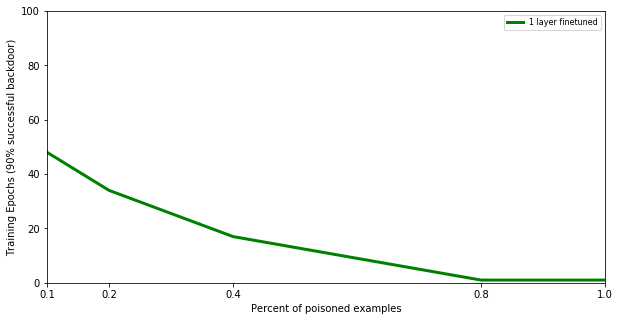

In [22]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))
lines = []

colors = ["green", "red", "green", "blue", "yellow", "orange","brown","grey","purple"]
labels = ["1 layer finetuned", "2 layer finetuned", "3 layer finetuned"]

# batch_sizes = [50,25,10] # Dont have enough memory to run batch size 100
# learning_rates = [0.00001,0.0001,0.001]
i=0
# lines = []
# for loss in testTrainLosses:
num_percent_poisons = [0.1, 0.2, 0.4, 0.8, 1]
num_epochs1 = num_epochs[-1:]

for num_epoch in num_epochs1:

    
    line = mlines.Line2D(num_percent_poisons, num_epoch, color=colors[i], linewidth=3, label=labels[i])
    lines.append(line)
    ax.add_line(line)
    i=i+1

plt.legend(handles=lines, loc='upper right', fontsize=8)
plt.ylabel("Training Epochs (90% successful backdoor)", fontsize=10)
plt.xlabel("Percent of poisoned examples", fontsize=10)
axes = plt.gca()
axes.set_xticks(num_percent_poisons)
axes.set_xlim([0.1, 1])
axes.set_ylim([0, 100])
plt.show()
fig.savefig(attacker + "_" + attacker_label + "_1.png")